A notebook to illustrate/test `kmod.mctest.SC_MMD`.

In [73]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import kmod
import kgof
import kgof.goftest as gof
# submodules
from kmod import data, density, kernel, util
from kmod import mctest as mct
import matplotlib
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.stats as stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## A simple 1d Gaussian problem

Two models $P = \mathcal{N}(\mu_p, \sigma_p^2)$ and $Q = \mathcal{N}(\mu_q, \sigma^2_q)$. The data generating distribution is $R = \mathcal{N}(0, 1)$.

    H_0: P, Q are equally good
    H_1: Q is better for approximating R

### Case 1: $Q$ is actually better than $P$

In [75]:
mp, varp = 0.55, 1.
# q cannot be the true model. 
# That violates our assumption and the asymptotic null distribution
# does not hold.
mq, varq = 0.5, 1.
# draw some data
n = 600 # sample size
seed = 8
with util.NumpySeedContext(seed=seed):
    X = np.random.randn(n, 1)*varp**0.5 + mp
    Y = np.random.randn(n, 1)*varq**0.5 + mq
    Z = np.random.randn(n, 1)
    
    datap = data.Data(X)
    dataq = data.Data(Y)
    datar = data.Data(Z)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


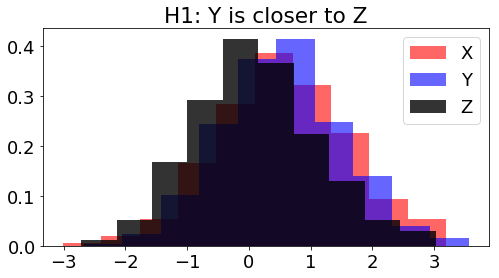

In [76]:
# plot the data
plt.figure(figsize=(8, 4))
plt.hist(X, color='r', alpha=0.6, normed=True, label='X')
plt.hist(Y, color='b', alpha=0.6, normed=True, label='Y')
plt.hist(Z, color='k', alpha=0.8, normed=True, label='Z')
plt.title('H1: Y is closer to Z')
plt.legend()

### Use median heuristic for the Gaussian widths

In [77]:
# hyperparameters of the test
medxz = util.meddistance(np.vstack((X, Z)), subsample=1000)
medyz = util.meddistance(np.vstack((Y, Z)), subsample=1000)
medxyz = np.mean([medxz, medyz])
k = kernel.KGauss(sigma2=medxyz**2)

In [78]:
# construct a MMD similarity test
alpha = 0.01 # significance level 
scummd = mct.SC_MMD(datap, dataq, k, alpha=alpha)
scummd.perform_test(datar)

{'alpha': 0.01,
 'pvalue': 1.639164547048069e-17,
 'test_stat': 0.09897013695467394,
 'h0_rejected': True,
 'time_secs': 0.14039111137390137}

### Case 2: Two models are equally good. 

In [79]:
mp, varp = 0.5, 1.
# q cannot be the true model. 
# That violates our assumption and the asymptotic null distribution
# does not hold.
mq, varq = 0.5, 1.
# draw some data
n = 600 # sample size
seed = 8
with util.NumpySeedContext(seed=seed):
    X = np.random.randn(n, 1)*varp**0.5 + mp
    Y = np.random.randn(n, 1)*varq**0.5 + mq
    Z = np.random.randn(n, 1)
    
    datap = data.Data(X)
    dataq = data.Data(Y)
    datar = data.Data(Z)

In [80]:
# hyperparameters of the test
medxz = util.meddistance(np.vstack((X, Z)), subsample=1000)
medyz = util.meddistance(np.vstack((Y, Z)), subsample=1000)
medxyz = np.mean([medxz, medyz])
k = kernel.KGauss(sigma2=medxyz**2)

In [81]:
# construct a MMD similarity test
alpha = 0.01 # significance level 
scummd = mct.SC_MMD(datap, dataq, k, alpha=alpha)
scummd.perform_test(datar)

{'alpha': 0.01,
 'pvalue': 1.0,
 'test_stat': -0.11272538080104455,
 'h0_rejected': False,
 'time_secs': 0.1384880542755127}

# Debugging

Normal usage will not need the following code. The following code is here for checking the implementation during the development.

Check the asymptotic distribution of the SC_UME statistic.

In [ ]:
def gen_test_samples(n, seed):
    """
    Return datap, dataq, datar
    """
    mp, varp = 2, 1
    mq, varq = 1, 1

    # draw some data
    
    with util.NumpySeedContext(seed=seed):
        X = np.random.randn(n, 1)*varp**0.5 + mp
        Y = np.random.randn(n, 1)*varq**0.5 + mq
        Z = np.random.randn(n, 1)

        datap = data.Data(X)
        dataq = data.Data(Y)
        datar = data.Data(Z)
    return datap, dataq, datar

In [ ]:
seed = 988
n = 500 # sample size
datap, dataq, datar = gen_test_samples(n, seed)
X, Y, Z = [a.data() for a in [datap, dataq, datar]]

In [ ]:
# plot the data
plt.figure(figsize=(8, 4))
plt.hist(X, color='r', alpha=0.6, normed=True, label='X')
plt.hist(Y, color='b', alpha=0.6, normed=True, label='Y')
plt.hist(Z, color='k', alpha=0.8, normed=True, label='Z')
plt.title('H1: Y is closer to Z')
plt.legend()

In [ ]:
# hyperparameters of the test
medxz = util.meddistance(np.vstack((X, Z)), subsample=1000)
medyz = util.meddistance(np.vstack((Z, Y)), subsample=1000)
k = kernel.KGauss(sigma2=medxz**2)
l = kernel.KGauss(sigma2=medyz**2)

# 2 sets of test locations
J = 2
Jp = J
Jq = J
V = util.fit_gaussian_draw(X, Jp, seed=seed+2)
W = util.fit_gaussian_draw(Y, Jq, seed=seed+3)

In [ ]:
# number of times to create a new problem (draw new samples)
trials = 300
null_stats = np.zeros(trials)
alpha = 0.01 # significance level 

for t in range(trials):
    datap, dataq, datar = gen_test_samples(n, seed=t+83)
    # create a UME test
    
    scume = mct.SC_UME(datap, dataq, k, l, V, W, alpha=alpha)
    null_stats[t] = scume.compute_stat(datar)

# use the data in the last trial to perform test
results = scume.perform_test(datar)

display(results)

In [ ]:
# get the parameters of the asymptotic null distribution
_, var_h0 = scume.get_H1_mean_variance(datar, return_variance=True)
dom =  np.linspace(np.min(null_stats)-1, np.max(null_stats)+2, 300)
ph0_values = stats.norm.pdf(dom, loc=0, scale=var_h0**0.5)

In [ ]:
# histogram of the null stats
plt.figure(figsize=(8, 5))

plt.plot(dom, ph0_values, 'r-', label='Asymp. null dist.')
plt.hist(null_stats, label='Empirical ground truth', alpha=0.7, bins=15, normed=True);
# plt.hist(sim_stats, label='Asymptotic', alpha=0.7, bins=15, normed=True)
plt.legend()

When $H_0$ is true, the asymptotic null distribution is expected to be to the right of the empirically obtained statistics. This means that we will have type-I error which is lower than $\alpha$, but lose a bit of test power.